### Imports

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

### Funções

In [2]:
def load_data(file_path):
    return pd.read_parquet(file_path)

def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

def create_classification_report_df(class_reports,model_names):
    if len(class_reports) != len(model_names):
        raise ValueError("O número de relatórios de classificação deve ser igual ao número de nomes de modelos.")

    all_reports = []

    for report, model_name in zip(class_reports, model_names):
        # Verificar se as chaves esperadas existem no relatório
        data = {
            'Model': model_name,
            'Accuracy': report.get('accuracy', None),
            'Class 0 Precision': report.get('0', {}).get('precision', None),
            'Class 0 Recall': report.get('0', {}).get('recall', None),
            'Class 0 F1-Score': report.get('0', {}).get('f1-score', None),
            'Class 1 Precision': report.get('1', {}).get('precision', None),
            'Class 1 Recall': report.get('1', {}).get('recall', None),
            'Class 1 F1-Score': report.get('1', {}).get('f1-score', None),
            'Class 2 Precision': report.get('2', {}).get('precision', None),
            'Class 2 Recall': report.get('2', {}).get('recall', None),
            'Class 2 F1-Score': report.get('2', {}).get('f1-score', None),
            'Macro Avg Precision': report.get('macro avg', {}).get('precision', None),
            'Macro Avg Recall': report.get('macro avg', {}).get('recall', None),
            'Macro Avg F1-Score': report.get('macro avg', {}).get('f1-score', None),
            'Weighted Avg Precision': report.get('weighted avg', {}).get('precision', None),
            'Weighted Avg Recall': report.get('weighted avg', {}).get('recall', None),
            'Weighted Avg F1-Score': report.get('weighted avg', {}).get('f1-score', None)
        }
        all_reports.append(data)

    return pd.DataFrame(all_reports)
def evaluate_feature_importance(model, x_train, x_test, y_train, y_test):
    accuracies = []
    features = x_train.columns
    for feature in features:
        x_train_temp = x_train.drop(columns=[feature])
        x_test_temp = x_test.drop(columns=[feature])
        model.fit(x_train_temp, y_train)
        y_pred_temp = model.predict(x_test_temp)
        accuracy = accuracy_score(y_test, y_pred_temp)
        accuracies.append((feature, accuracy))
    return accuracies

def evaluate_model(model, x_train, x_test, y_train, y_test):
    """
    Avalia um modelo e retorna as métricas de desempenho para treino e teste.

    Args:
        model: O modelo a ser avaliado.
        x_train: Dados de treino.
        x_test: Dados de teste.
        y_train: Rótulos de treino.
        y_test: Rótulos de teste.

    Returns:
        Um dicionário com as métricas de desempenho.
    """

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train, y_pred_train),
            'precision': precision_score(y_train, y_pred_train, average='macro'),
            'recall': recall_score(y_train, y_pred_train, average='macro'),
            'f1': f1_score(y_train, y_pred_train, average='macro')
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_pred_test),
            'precision': precision_score(y_test, y_pred_test, average='macro'),
            'recall': recall_score(y_test, y_pred_test, average='macro'),
            'f1': f1_score(y_test, y_pred_test, average='macro')
        }
    }

    return metrics



### Carregando dados

In [3]:
seed = 42
file_path = '../data/outputs/costumers_feature_df.parquet'
file_path2 = '../data/outputs/feature_df.parquet'
file_path3 = '../data/outputs/finale_df.parquet'
file_path4 = '../data/outputs/score_df_1.parquet' # Filtro 1 e 2 // 3 e 4 // 5
file_path5 = '../data/outputs/score_df_2.parquet' # Filtro 1 e 2 // 3 // 4 e 5
file_path6 = '../data/outputs/score_df_3.parquet' # Filtro 1 // 2, 3 e 4 // 5
df = load_data(file_path6)
##display(df)

rating = df['review_score_factor']
#rating = df['review_score']

drop_columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 'review_comment_title', 'review_score', \
                'review_creation_date', 'review_comment_message', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'customer_unique_id', \
                'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', \
                'freight_value', 'product_category_name', 'product_length_cm', 'product_height_cm', 'product_width_cm', \
                'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_score_factor', 'delivery']

features = df.drop(drop_columns, axis=1)
features = features.fillna(features.mean())

In [4]:
features.head()

,payment_installments,payment_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,comp_score,neg,pos,neu,polarity,price_factor,freight_value_factor,if_delivered,actual_est_delivery_diff,delivery_duration,delivery_time_diff
0,1,18.12,40.0,268.0,4.0,500.0,0.5023,0.126,0.193,0.681,1,0.0,0.0,1.0,7.0,8.0,-8.0
1,1,2.00,40.0,268.0,4.0,500.0,0.5023,0.126,0.193,0.681,1,0.0,0.0,1.0,7.0,8.0,-8.0
2,1,18.59,40.0,268.0,4.0,500.0,0.5023,0.126,0.193,0.681,1,0.0,0.0,1.0,7.0,8.0,-8.0
3,3,37.77,40.0,268.0,4.0,500.0,0.7003,0.000,0.367,0.633,1,0.0,0.0,1.0,9.0,2.0,-10.0
4,1,37.77,40.0,268.0,4.0,500.0,0.4215,0.000,0.219,0.781,1,0.0,0.0,1.0,7.0,5.0,-8.0


### Dividindo os dados

In [5]:

x_train, x_test, y_train, y_test = train_test_split(features, rating, test_size = 0.2, random_state = seed)

### Criação e treinamento do modelo de XGBoost

c:\Users\Matheus\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.6803584012886339
Classification Report:
{'0.0': {'precision': 0.6907838070628768, 'recall': 0.6949740034662045, 'f1-score': 0.6928725701943844, 'support': 2308.0}, '1.0': {'precision': 0.5519001701644923, 'recall': 0.3364453665283541, 'f1-score': 0.4180451127819549, 'support': 2892.0}, '2.0': {'precision': 0.7149452804377565, 'recall': 0.8833720684555251, 'f1-score': 0.790284472167092, 'support': 4733.0}, 'accuracy': 0.6803584012886339, 'macro avg': {'precision': 0.6525430858883753, 'recall': 0.6382638128166945, 'f1-score': 0.633734051714477, 'support': 9933.0}, 'weighted avg': {'precision': 0.661860498452505, 'recall': 0.6803584012886339, 'f1-score': 0.6592724015847075, 'support': 9933.0}}


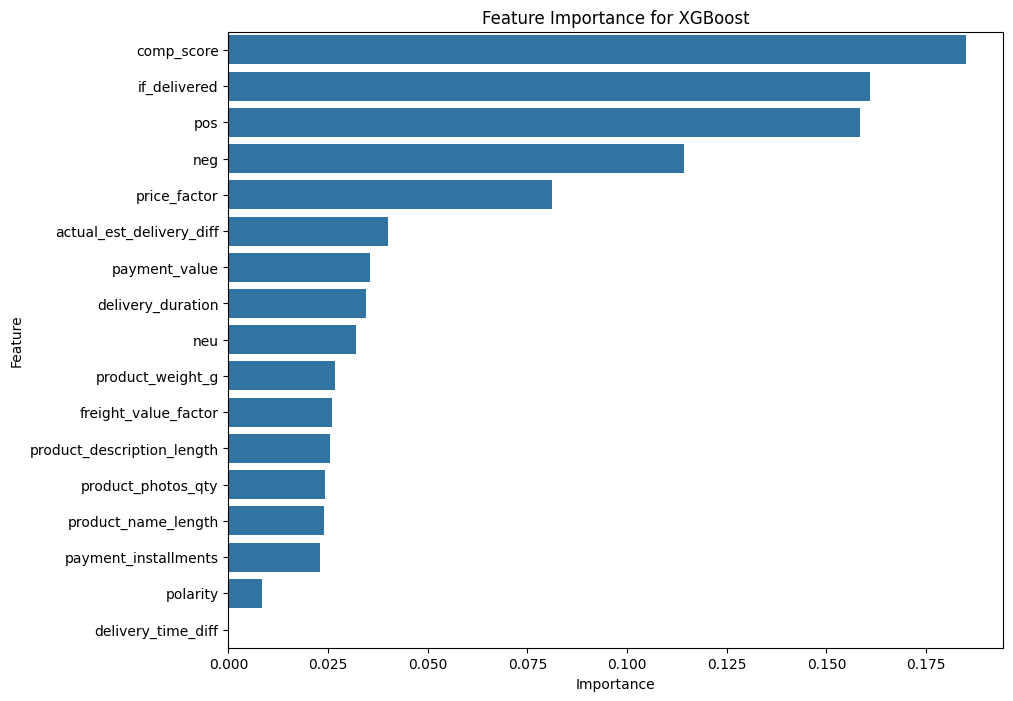

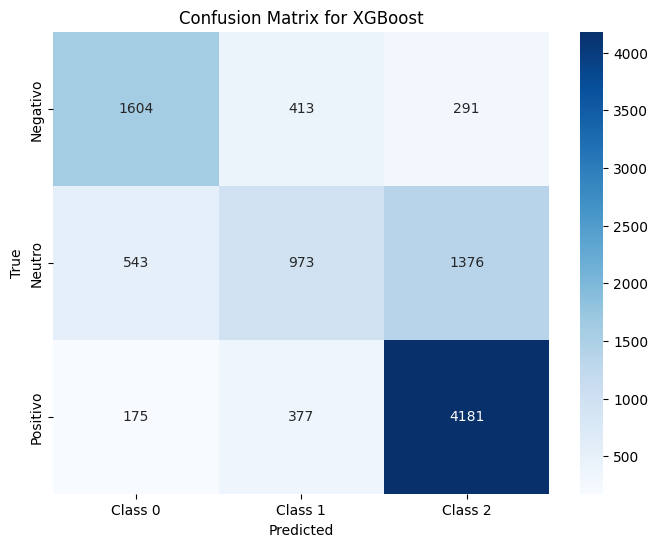

In [6]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit model
xgb_model.fit(x_train, y_train)

# Make predictions
y_pred = xgb_model.predict(x_test)

# Evaluate model
accuracy_xgb = accuracy_score(y_test, y_pred)
conf_matrix_xgb = confusion_matrix(y_test, y_pred)
class_report_xgb = classification_report(y_test, y_pred, output_dict=True)

print("XGBoost Model")
print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:")
print(class_report_xgb)

# Feature Importance for XGBoost
importance = xgb_model.feature_importances_
features_names = x_train.columns
importance_df = pd.DataFrame({'Feature': features_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for XGBoost')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo de Árvore de decisão

{'0.0': {'precision': 0.6907838070628768, 'recall': 0.6949740034662045, 'f1-score': 0.6928725701943844, 'support': 2308.0}, '1.0': {'precision': 0.5519001701644923, 'recall': 0.3364453665283541, 'f1-score': 0.4180451127819549, 'support': 2892.0}, '2.0': {'precision': 0.7149452804377565, 'recall': 0.8833720684555251, 'f1-score': 0.790284472167092, 'support': 4733.0}, 'accuracy': 0.6803584012886339, 'macro avg': {'precision': 0.6525430858883753, 'recall': 0.6382638128166945, 'f1-score': 0.633734051714477, 'support': 9933.0}, 'weighted avg': {'precision': 0.661860498452505, 'recall': 0.6803584012886339, 'f1-score': 0.6592724015847075, 'support': 9933.0}}


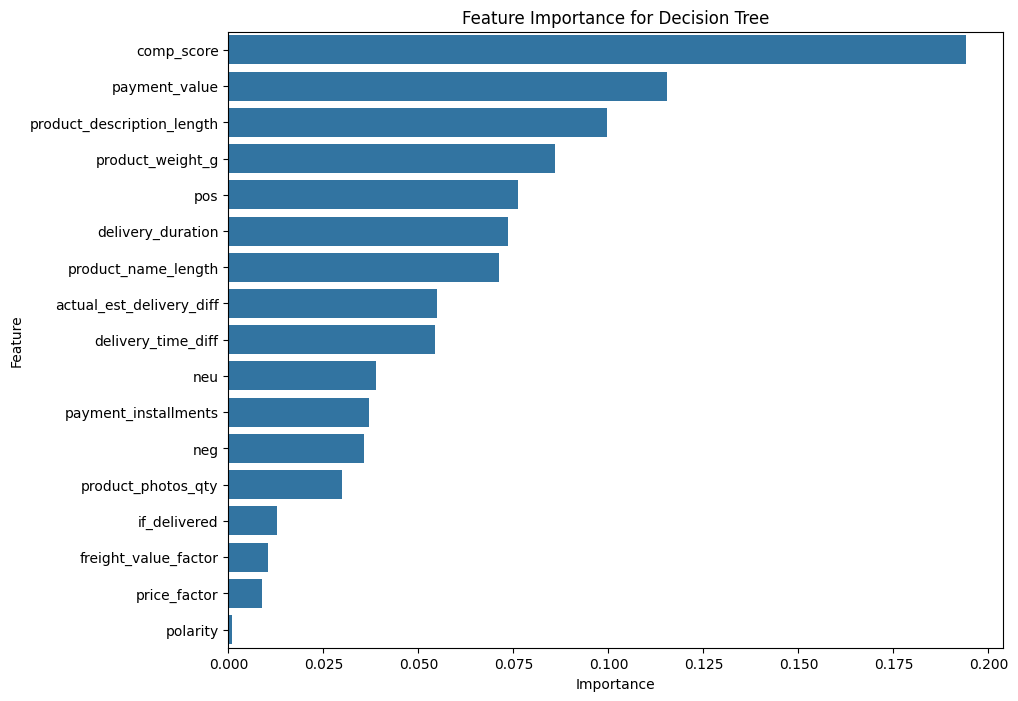

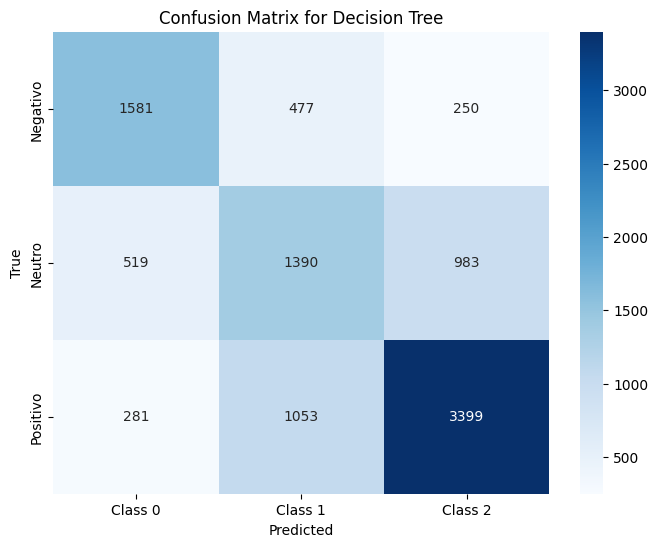

In [7]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

# Realização de previsões
y_pred_dt = clf.predict(x_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred,output_dict=True)
print(class_report_dt)

importance_dt = clf.feature_importances_
importance_df_dt = pd.DataFrame({'Feature': features_names, 'Importance': importance_dt})
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_dt)
plt.title('Feature Importance for Decision Tree')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo de regressão logística

c:\Users\Matheus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'0.0': {'precision': 0.5731402895656516, 'recall': 0.49740034662045063, 'f1-score': 0.5325910461609835, 'support': 2308.0}, '1.0': {'precision': 0.3522727272727273, 'recall': 0.22510373443983403, 'f1-score': 0.2746835443037975, 'support': 2892.0}, '2.0': {'precision': 0.6568562972706347, 'recall': 0.8440735263046694, 'f1-score': 0.7387887193712437, 'support': 4733.0}, 'accuracy': 0.5833081647035135, 'macro avg': {'precision': 0.5274231047030046, 'recall': 0.522192535788318, 'f1-score': 0.5153544366120082, 'support': 9933.0}, 'weighted avg': {'precision': 0.5487245918224267, 'recall': 0.5833081647035135, 'f1-score': 0.5557527386942746, 'support': 9933.0}}


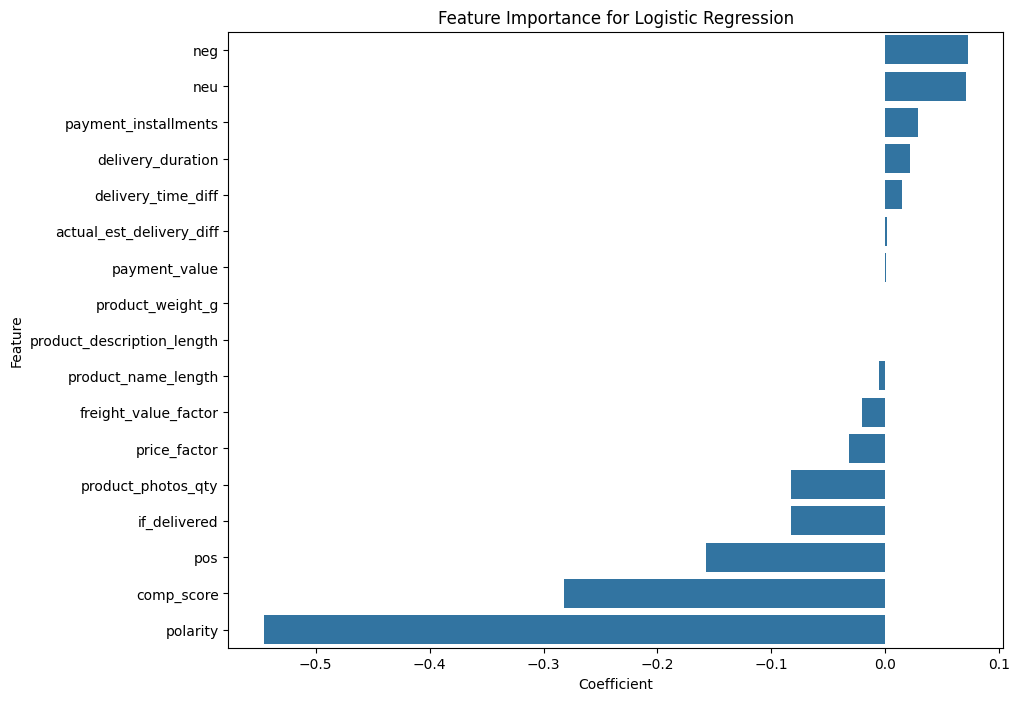

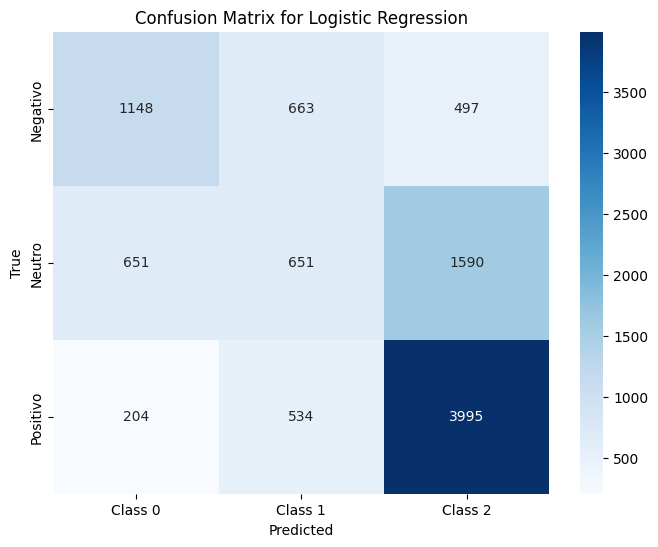

In [8]:
# Criar e treinar o modelo de regressão logística
model = LogisticRegression(max_iter=1000, random_state=seed)
model.fit(x_train, y_train)

# Fazer previsões e avaliar o modelo
y_pred_lr = model.predict(x_test)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
class_report_lr = classification_report(y_test, y_pred_lr,output_dict=True)
print(class_report_lr)

coefficients = model.coef_[0]
importance_lr_df = pd.DataFrame({'Feature': features_names, 'Coefficient': coefficients})
importance_lr_df = importance_lr_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_lr_df)
plt.title('Feature Importance for Logistic Regression')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo com regressão linear

In [9]:

reg = lm.LinearRegression().fit(x_train, y_train)

y_pred_lr = reg.predict(x_test)

score = reg.score(x_test, y_test)
rmse_lr = np.sqrt(mean_squared_error(y_test.values, y_pred_lr))

print(f'The R2 score in this linear regression model is {round(score, 5)}')
print(f'The RMSE in this linear regression model is {round(rmse_lr, 5)}, which is about {100*round(rmse_lr/np.mean(rating),2)}% of \
the mean rating score.')

The R2 score in this linear regression model is 0.38621
The RMSE in this linear regression model is 0.63127, which is about 51.0% of the mean rating score.


### Criação e treinamento do modelo com floresta aleatória

The accuracy of the RF model is 0.73301
Classification Report for Random Forest:
{'0.0': {'precision': 0.7467667918231122, 'recall': 0.7755632582322357, 'f1-score': 0.7608926673751328, 'support': 2308.0}, '1.0': {'precision': 0.6527850078084331, 'recall': 0.4336099585062241, 'f1-score': 0.521088718055267, 'support': 2892.0}, '2.0': {'precision': 0.7545859305431879, 'recall': 0.8952038875977182, 'f1-score': 0.8189022033243138, 'support': 4733.0}, 'accuracy': 0.73301117487164, 'macro avg': {'precision': 0.7180459100582444, 'recall': 0.7014590347787261, 'f1-score': 0.7002945295849047, 'support': 9933.0}, 'weighted avg': {'precision': 0.723129689657771, 'recall': 0.73301117487164, 'f1-score': 0.7187146861221803, 'support': 9933.0}}


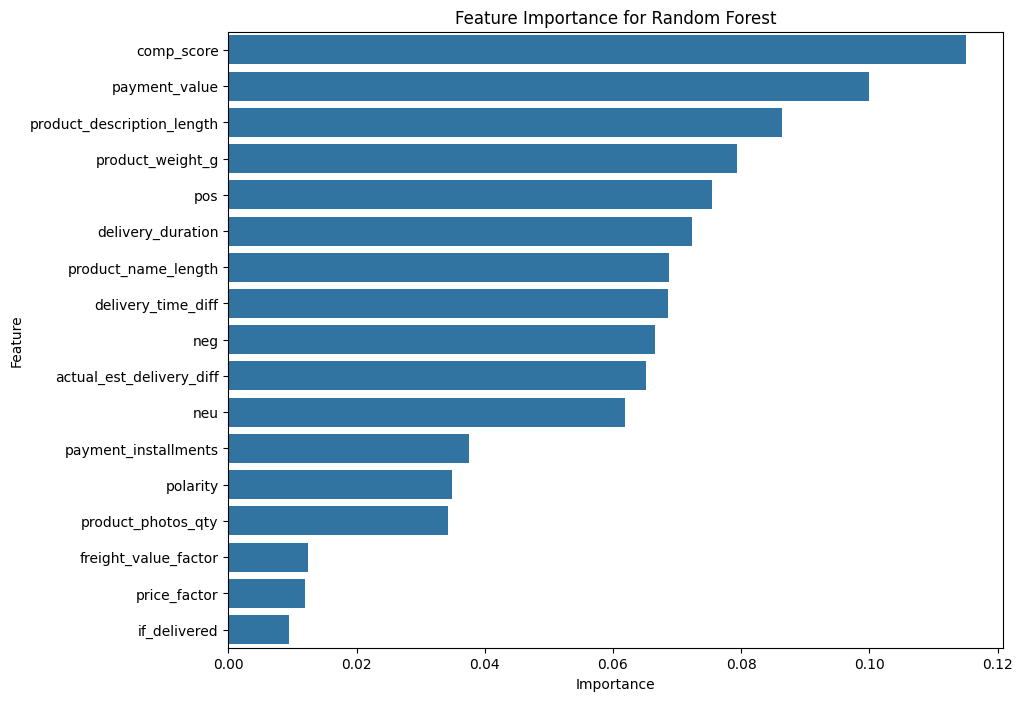

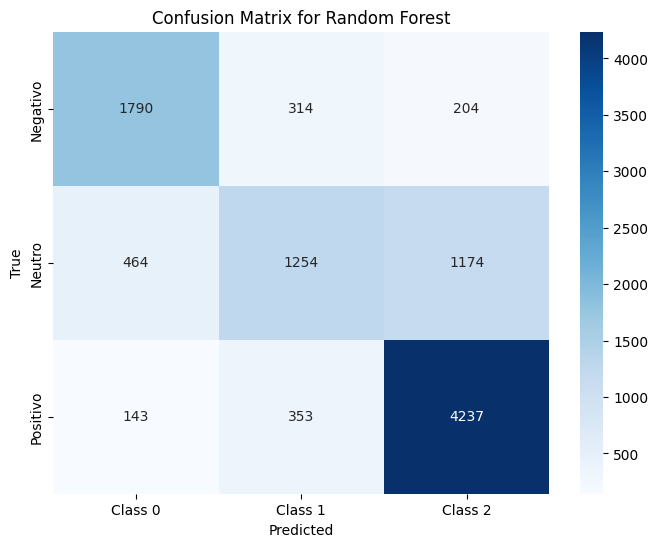

In [10]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=seed)

# Ajuste o modelo com os dados de treinamento
model_rf.fit(x_train, y_train)

# Fazer previsões
y_pred_rf = model_rf.predict(x_test)

# Avaliar o modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(f'The accuracy of the RF model is {round(accuracy_rf, 5)}')

# Exibir relatório de classificação
class_report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
print("Classification Report for Random Forest:")
print(class_report_rf)

# Feature Importance for Random Forest
# Certifique-se de que o modelo foi ajustado corretamente antes de acessar 'feature_importances_'
importance_rf = model_rf.feature_importances_
features_names = x_train.columns  # Obtendo os nomes das características

# Criação do DataFrame para importâncias
importance_df_rf = pd.DataFrame({'Feature': features_names, 'Importance': importance_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Plotagem da importância das características
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Feature Importance for Random Forest')
plt.show()

# Plotagem da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo utilizando KNN

The accuracy of the KNN model is 0.48747
{'0.0': {'precision': 0.42523768366465, 'recall': 0.42634315424610053, 'f1-score': 0.42578970142795325, 'support': 2308.0}, '1.0': {'precision': 0.3806499813223758, 'recall': 0.35235131396957126, 'f1-score': 0.3659543903752918, 'support': 2892.0}, '2.0': {'precision': 0.5744637798462161, 'recall': 0.5998309740122544, 'f1-score': 0.5868733850129199, 'support': 4733.0}, 'accuracy': 0.4874660223497433, 'macro avg': {'precision': 0.4601171482777473, 'recall': 0.459508480742642, 'f1-score': 0.45953915893872166, 'support': 9933.0}, 'weighted avg': {'precision': 0.4833610580785728, 'recall': 0.4874660223497433, 'f1-score': 0.48512377520660527, 'support': 9933.0}}


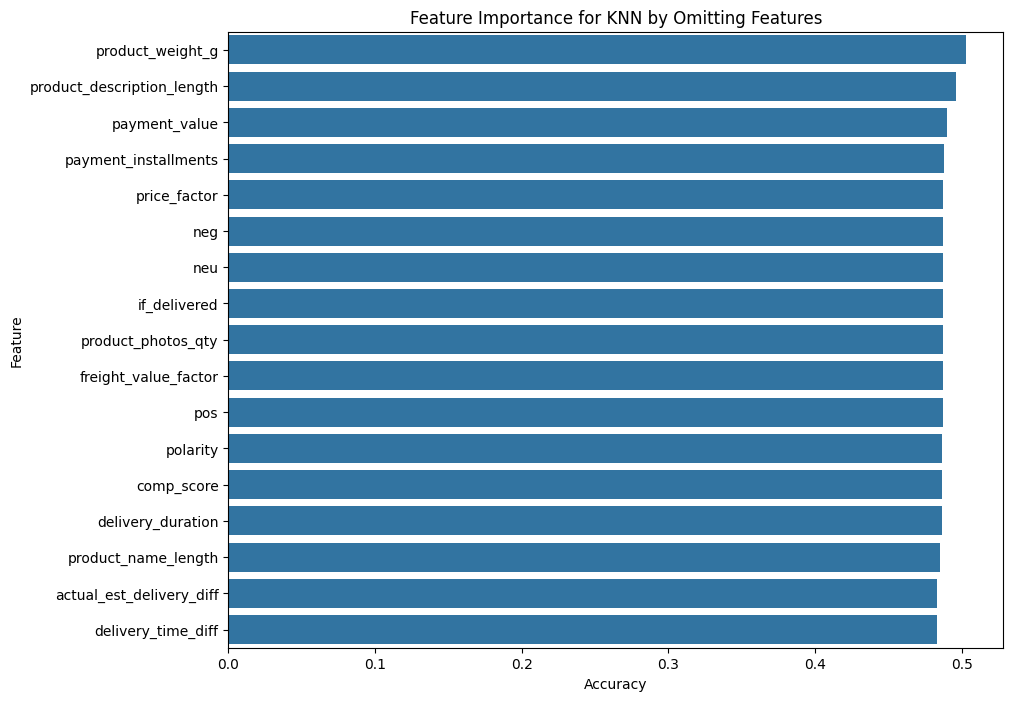

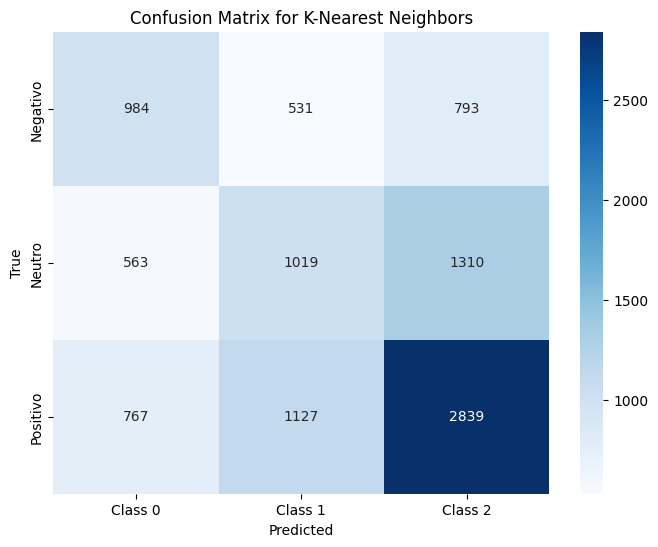

In [11]:
# Criar e treinar o modelo K-Nearest Neighbors
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(x_train, y_train)

# Fazer previsões
y_pred_knn = model_knn.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(f'The accuracy of the KNN model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_knn = classification_report(y_test, y_pred_knn,output_dict=True)
print(class_report_knn)

feature_importance_knn = evaluate_feature_importance(model_knn, x_train, x_test, y_train, y_test)
importance_df_knn = pd.DataFrame(feature_importance_knn, columns=['Feature', 'Accuracy'])
importance_df_knn = importance_df_knn.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Accuracy', y='Feature', data=importance_df_knn)
plt.title('Feature Importance for KNN by Omitting Features')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo utilizando GBM

The accuracy of the Gradient Boosting model is 0.64099
{'0.0': {'precision': 0.6469804618117229, 'recall': 0.6312824956672444, 'f1-score': 0.6390350877192983, 'support': 2308.0}, '1.0': {'precision': 0.4670967741935484, 'recall': 0.2503457814661134, 'f1-score': 0.3259792886087348, 'support': 2892.0}, '2.0': {'precision': 0.6827597455553743, 'recall': 0.8844284808789351, 'f1-score': 0.770618556701031, 'support': 4733.0}, 'accuracy': 0.6409946642504782, 'macro avg': {'precision': 0.5989456605202151, 'recall': 0.5886855860040976, 'f1-score': 0.5785443110096881, 'support': 9933.0}, 'weighted avg': {'precision': 0.6116557588384964, 'recall': 0.6409946642504782, 'f1-score': 0.6105872056758865, 'support': 9933.0}}


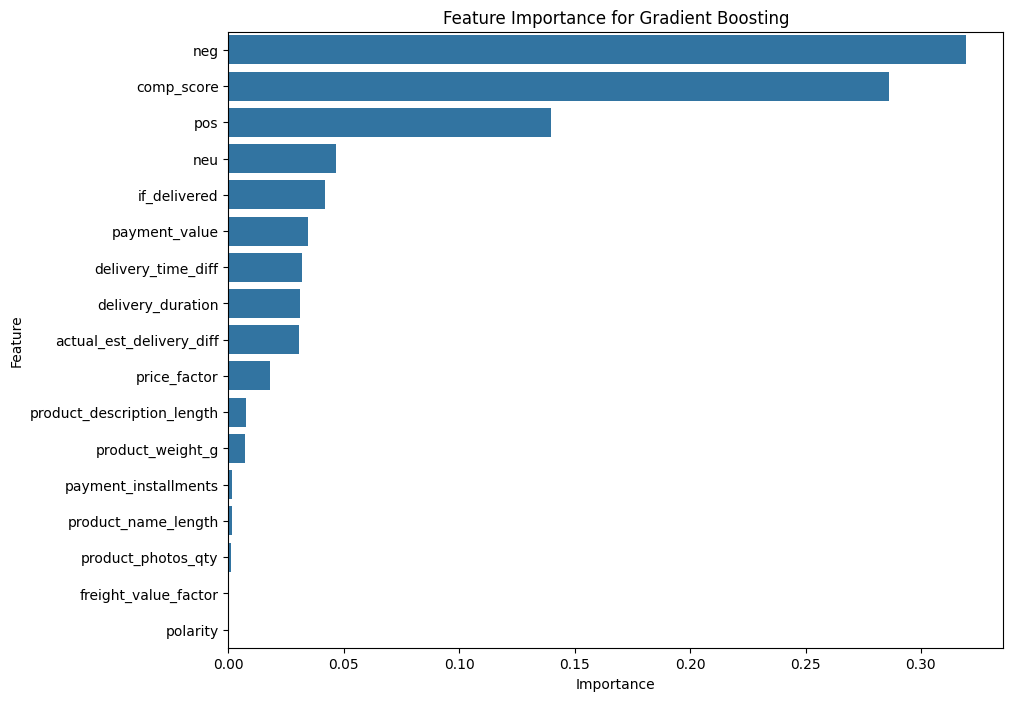

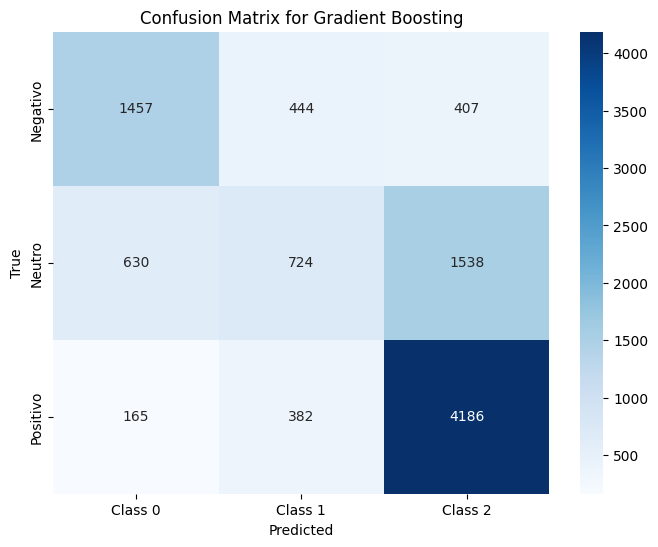

In [12]:
# Criar e treinar o modelo Gradient Boosting
model_gbm = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_gbm.fit(x_train, y_train)

# Fazer previsões
y_pred_gbm = model_gbm.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_gbm)
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
print(f'The accuracy of the Gradient Boosting model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_gbm = classification_report(y_test, y_pred_gbm,output_dict=True)
print(class_report_gbm)

# Feature Importance for Gradient Boosting
importance_gbm = model_gbm.feature_importances_
importance_df_gbm = pd.DataFrame({'Feature': features_names, 'Importance': importance_gbm})
importance_df_gbm = importance_df_gbm.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_gbm)
plt.title('Feature Importance for Gradient Boosting')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
# Lista de modelos e seus nomes
models = [
    ('Logistic Regression', model),
    ('Decision Tree', clf),
    ('Random Forest', model_rf),
    ('K-Nearest Neighbors', model_knn),
    ('Gradient Boosting', model_gbm),
    ('XGBoost', xgb_model)
]

# Lista para armazenar os resultados
results = []

# Avaliar cada modelo
for name, model in models:
    # Ensure the model is fitted with the same columns as the training data
    model.fit(x_train, y_train)
    metrics = evaluate_model(model, x_train, x_test, y_train, y_test)
    results.append({
        'Model': name,
        'Set': 'Train',
        'Accuracy': metrics['train']['accuracy'],
        'Precision': metrics['train']['precision'],
        'Recall': metrics['train']['recall'],
        'F1': metrics['train']['f1']
    })
    results.append({
        'Model': name,
        'Set': 'Test',
        'Accuracy': metrics['test']['accuracy'],
        'Precision': metrics['test']['precision'],
        'Recall': metrics['test']['recall'],
        'F1': metrics['test']['f1']
    })

# Criar um DataFrame a partir dos resultados
results_df = pd.DataFrame(results)
display(results_df)

c:\Users\Matheus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Matheus\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Set,Accuracy,Precision,Recall,F1
0,Logistic Regression,Train,0.587688,0.537078,0.531477,0.525564
1,Logistic Regression,Test,0.583308,0.527423,0.522193,0.515354
2,Decision Tree,Train,0.999849,0.999827,0.999894,0.999861
3,Decision Tree,Test,0.641297,0.624614,0.627931,0.626186
4,Random Forest,Train,0.999849,0.999838,0.999883,0.999861
5,Random Forest,Test,0.733011,0.718046,0.701459,0.700295
6,K-Nearest Neighbors,Train,0.663646,0.645151,0.641540,0.642843
7,K-Nearest Neighbors,Test,0.487466,0.460117,0.459508,0.459539
8,Gradient Boosting,Train,0.651414,0.611263,0.600988,0.590653
9,Gradient Boosting,Test,0.640995,0.598946,0.588686,0.578544


In [14]:
results_df.to_parquet('results.parquet')

In [15]:
class_reports = [class_report_xgb, class_report_rf, class_report_dt, class_report_lr, class_report_knn, class_report_gbm]
model_names = ['XGBoost', 'Random Forest', 'Decision Tree', 'Logistic Regression', 'K-Nearest Neighbors', 'Gradient Boosting']

results_df = create_classification_report_df(class_reports, model_names)
results_df.to_csv('../data/outputs/classification_reports.csv', index=False)

# Exibir o DataFrame
print(results_df)

                 Model  Accuracy Class 0 Precision Class 0 Recall  \
0              XGBoost  0.680358              None           None   
1        Random Forest  0.733011              None           None   
2        Decision Tree  0.680358              None           None   
3  Logistic Regression  0.583308              None           None   
4  K-Nearest Neighbors  0.487466              None           None   
5    Gradient Boosting  0.640995              None           None   

  Class 0 F1-Score Class 1 Precision Class 1 Recall Class 1 F1-Score  \
0             None              None           None             None   
1             None              None           None             None   
2             None              None           None             None   
3             None              None           None             None   
4             None              None           None             None   
5             None              None           None             None   

  Class 2 P

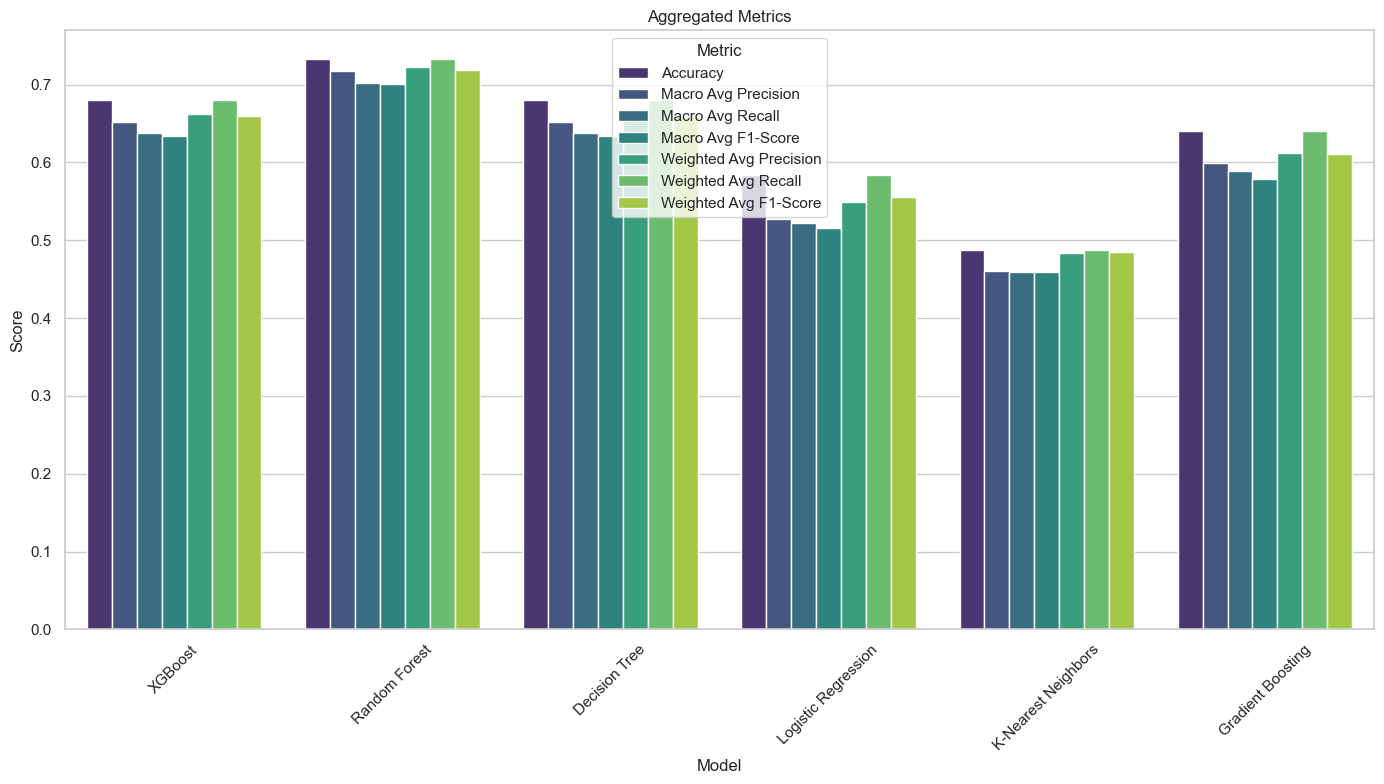

In [16]:
# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

metrics = ['Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1-Score',
           'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score']
metrics_df = results_df.melt(id_vars=['Model'], value_vars=metrics,
                             var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette="viridis")
plt.title('Aggregated Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Caminho para o arquivo CSV
file_path = '../data/outputs/classification_reports.csv'
columns_to_drop = [
    'Class 0 Precision',
    'Class 0 Recall',
    'Class 0 F1-Score',
    'Class 1 Precision',
    'Class 1 Recall',
    'Class 1 F1-Score',
    'Class 2 Precision',
    'Class 2 Recall',
    'Class 2 F1-Score'
]

# Carregar os dados
df = pd.read_csv(file_path)
df.head()

,Model,Accuracy,Class 0 Precision,Class 0 Recall,Class 0 F1-Score,Class 1 Precision,Class 1 Recall,Class 1 F1-Score,Class 2 Precision,Class 2 Recall,Class 2 F1-Score,Macro Avg Precision,Macro Avg Recall,Macro Avg F1-Score,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1-Score
0,XGBoost,0.680358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.652543,0.638264,0.633734,0.661860,0.680358,0.659272
1,Random Forest,0.733011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.718046,0.701459,0.700295,0.723130,0.733011,0.718715
2,Decision Tree,0.680358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.652543,0.638264,0.633734,0.661860,0.680358,0.659272
3,Logistic Regression,0.583308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527423,0.522193,0.515354,0.548725,0.583308,0.555753
4,K-Nearest Neighbors,0.487466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.460117,0.459508,0.459539,0.483361,0.487466,0.485124


In [18]:
columns_to_drop = [
    'Class 0 Precision',
    'Class 0 Recall',
    'Class 0 F1-Score',
    'Class 1 Precision',
    'Class 1 Recall',
    'Class 1 F1-Score',
    'Class 2 Precision',
    'Class 2 Recall',
    'Class 2 F1-Score'
]

# Verificar quais colunas estão presentes no DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Remover as colunas
df_cleaned = df.drop(columns=existing_columns_to_drop)

# Salvar o DataFrame limpo em um novo arquivo CSV
df_cleaned.to_csv("../data/outputs/classification_reports_clean.csv", index=False)


In [19]:
# Caminho para o arquivo CSV
file_path = '../data/outputs/classification_reports_clean.csv'

# Carregar os dados
df = pd.read_csv(file_path)
df.head()

,Model,Accuracy,Macro Avg Precision,Macro Avg Recall,Macro Avg F1-Score,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1-Score
0,XGBoost,0.680358,0.652543,0.638264,0.633734,0.661860,0.680358,0.659272
1,Random Forest,0.733011,0.718046,0.701459,0.700295,0.723130,0.733011,0.718715
2,Decision Tree,0.680358,0.652543,0.638264,0.633734,0.661860,0.680358,0.659272
3,Logistic Regression,0.583308,0.527423,0.522193,0.515354,0.548725,0.583308,0.555753
4,K-Nearest Neighbors,0.487466,0.460117,0.459508,0.459539,0.483361,0.487466,0.485124


In [20]:
importance_list = []
conf_matrix_list = []

model = LogisticRegression(max_iter=1000)
clf = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_gbm = GradientBoostingClassifier()
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

models = [
    ('Logistic Regression', model),
    ('Decision Tree', clf),
    ('Random Forest', model_rf),
    ('K-Nearest Neighbors', model_knn),
    ('Gradient Boosting', model_gbm),
    ('XGBoost', xgb_model)
]

importance_list = []
conf_matrix_list = []

for model_name, model in models:
    # Treinar o modelo
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Avaliar o modelo
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Verificar se o modelo possui 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': features.columns,
            'Importance': importance,
            'Model': model_name
        })
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        importance_list.append(importance_df)
    
    # Adicionar matriz de confusão ao DataFrame
    conf_matrix_df = pd.DataFrame(
        conf_matrix, 
        index=[f'Class {i}' for i in range(conf_matrix.shape[0])], 
        columns=[f'Class {i}' for i in range(conf_matrix.shape[1])]
    )
    conf_matrix_df['Model'] = model_name
    conf_matrix_list.append(conf_matrix_df)

# Concatenar todos os DataFrames de importâncias e salvar
if importance_list:
    importance_df_all = pd.concat(importance_list, ignore_index=True)
    importance_df_all.to_csv('all_feature_importances.csv', index=False)

# Concatenar todos os DataFrames de matrizes de confusão e salvar
conf_matrix_df_all = pd.concat(conf_matrix_list, ignore_index=False)
conf_matrix_df_all.to_csv('all_confusion_matrices.csv')

c:\Users\Matheus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Definições dos modelos
model = LogisticRegression(max_iter=1000)
clf = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_gbm = GradientBoostingClassifier()
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

models = [
    ('Logistic Regression', model),
    ('Decision Tree', clf),
    ('Random Forest', model_rf),
    ('K-Nearest Neighbors', model_knn),
    ('Gradient Boosting', model_gbm),
    ('XGBoost', xgb_model)
]

conf_matrix_list = []

for model_name, model in models:
    # Treinar o modelo
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Avaliar o modelo
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Adicionar matriz de confusão ao DataFrame
    conf_matrix_df = pd.DataFrame(
        conf_matrix, 
        index=[f'Class {i}' for i in range(conf_matrix.shape[0])], 
        columns=[f'Class {i}' for i in range(conf_matrix.shape[1])]
    )
    conf_matrix_df['Model'] = model_name
    conf_matrix_df.reset_index(inplace=True)
    conf_matrix_df = conf_matrix_df.melt(id_vars=['index', 'Model'], var_name='Class', value_name='Count')
    conf_matrix_df.rename(columns={'index': 'Actual'}, inplace=True)
    
    conf_matrix_list.append(conf_matrix_df)

# Concatenar todos os DataFrames de matrizes de confusão e salvar
conf_matrix_df_all = pd.concat(conf_matrix_list, ignore_index=True)
conf_matrix_df_all.to_csv('new_all_confusion_matrices.csv', index=False)


c:\Users\Matheus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
